# HyperoptによるScikit-learn(SVC)のハイパーパラメータチューニング

In [1]:
import numpy as np
from hyperopt import hp, tpe, Trials, fmin


# データの取得と整形

In [2]:
num_x = 1200

# MNIST(手書き文字） 10ラベル,64次元
from sklearn.datasets import load_digits
digits = load_digits(n_class=10)
data = digits['data']
data = data / np.max(digits['data'])
target = digits['target']

# 1200個の教師データと、597の試験データに分割
x_train, x_test = data[:num_x], data[num_x:]
y_train, y_test = target[:num_x], target[num_x:]

from collections import Counter

### 下記print文の動作確認ログ（不要）
## sorted keyの動作確認
#a = [[0,1],[1,2],[2,3],[0,4],[1,5],[1,6]    ]
#print(sorted(a, key=lambda x:x[0]))
## [[0, 1], [0, 4], [1, 2], [1, 5], [1, 6], [2, 3]]
## リストa を、lambda式の中身(x[0])でソートする
## それぞれのラベル毎(key)にソートする
#print(sorted(y_train, key=lambda x:x))
## リストを渡すと、キーに要素、値に出現回数を持つ、ペアのタプルのリストになる
#print(Counter(y_train).items())
## リストkvのkey(0~10)でsortして、表示をする
#kv = Counter(y_train).items()
#print(sorted([(key, value) for key, value in kv], key=lambda x:x[0]))

# それぞれのラベル毎(key)に、データが何件あるか(value)を数える
print ('学習用データ', sorted([(key, value) for key, value in Counter(y_train).items()], key=lambda x:x[0]))
print ('チューニング用データ', sorted([(key, value) for key, value in Counter(y_test).items()], key=lambda x:x[0]))


学習用データ [(0, 119), (1, 121), (2, 117), (3, 121), (4, 120), (5, 123), (6, 120), (7, 118), (8, 119), (9, 122)]
チューニング用データ [(0, 59), (1, 61), (2, 60), (3, 62), (4, 61), (5, 59), (6, 61), (7, 61), (8, 55), (9, 58)]


### Hyperoptを使用するための評価関数とパラメータ探索空間の設定
### Scikit-Learnでモデルを作り、F値を評価関数とする

In [3]:
# パラメータ探索空間
hyperopt_parameters = {
    # log_uniformは範囲指定(exp(uniform(low, high))のような対数に一様分布)
    'C': hp.loguniform('C', -8, 2),
    'gamma': hp.loguniform('gamma', -8, 2),
    # hp.choiceは、リストのどれか１つを選択する
    'kernel': hp.choice('kernel', ['rbf', 'poly', 'sigmoid'])
}

from sklearn.svm import SVC
from sklearn.metrics import f1_score
# 評価関数
# argsには、設定した探索するパラメータが渡される
def objective(args):
    # SVMによるモデルの作成と学習
    ## **argsは可変長引数、辞書に含まれる複数の要素を、それぞれの引数として渡す
    model = SVC(**args)
    model.fit(x_train, y_train)
    # 学習したモデルのF値を評価指標とする
    predicts = model.predict(x_test)
    f1 = f1_score(y_test, predicts, average='micro')
    # hyperoptは最小化を返すため、最大化を求める場合は-1をかける
    return -1*f1

# Hyperoptの実行とチューニングの実施

In [4]:
# 試行回数
max_evals = 200
# 試行の過程を記録するインスタンス
trials = Trials()

# hyperopt.fmin()により、探索空間における最小の値を探索する
best = fmin(
    # 1.最小化する関数の定義
    objective,
    # 2.探索空間の設定
    hyperopt_parameters,
    # 3.どのロジックを利用するか、基本的にはtpe.suggestでOK
    algo=tpe.suggest,
    # 4.iterationする回数
    max_evals=max_evals,
    # 試行の過程を記録
    trials=trials,
    # 試行の過程を出力
    verbose=1
)

# 実行結果の確認

In [7]:
print(best)
print('ベストスコア')
print('micro_f1 : ', -1*trials.best_trial['result']['loss'])
print('C        : ', best['C'])
print('gamma    : ', best['gamma'])
print('kernel   : ', ['rbf', 'poly', 'sigmoid'][best['kernel']])


{'C': 2.016404394551364, 'gamma': 0.22702333600100658, 'kernel': 0}
ベストスコア
micro_f1 :  0.9698492462311558
C        :  2.016404394551364
gamma    :  0.22702333600100658
kernel   :  rbf


# Hyperoptの実行時間の測定

In [9]:
max_evals = 200

def hyperopt_search(max_evals):
    trials = Trials()
    best = fmin(objective, hyperopt_parameters, algo=tpe.suggest, max_evals=max_evals, trials=trials)
    return -1*trials.best_trial['result']['loss']

%timeit hyperopt_search(max_evals)
# 38.1 s ± 1.03 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


38.1 s ± 1.03 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 比較としてランダムサーチによる実行時間の測定

In [10]:
num_iter = 200

def random_search(num_iter):
    results = []
    for _ in range(num_iter):
        random_params = {
            'C': np.exp(np.random.uniform(-8, 2)),
            'gamma': np.exp(np.random.uniform(-8, 2)),
            'kernel': str(np.random.choice(['rbf', 'poly', 'sigmoid']))
        }
        model = SVC(**random_params)
        model.fit(x_train, y_train)
        predicts = model.predict(x_test)
        f1 = f1_score(y_test, predicts, average='micro')
        results.append((f1, random_params))
    return sorted(results, key=lambda x:x[0], reverse=True)[0]

%timeit random_search(num_iter)

44.8 s ± 1.24 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


* Hyperopt     : 38.1 s ± 1.03 s
* RandomSearch : 44.8 s ± 1.24 s

# 精度の比較

In [11]:
# このコードは時間がかかるので簡単に実行しない（１時間以上）
# 精度の比較がしたいのであれば、下のグラフを見るだけで良い

num_epoch = 100
num_iter = 50

f1s_h = []
f1s_r = []

for epoch in range(1, num_epoch+1):
    f1_hyperopt = hyperopt_search(num_iter)
    f1_random = random_search(num_iter)
    f1s_h.append(f1_hyperopt)
    f1s_r.append(f1_random)
    

In [30]:
#print(f1s_r)
#(0.9564489112227805, {'C': 6.656751129818089, 'gamma': 0.6659230612613102, 'kernel': 'rbf'})
f1s_r2 = []
for i in range(len(f1s_r)):
    f1s_r2.append(f1s_r[i][0])


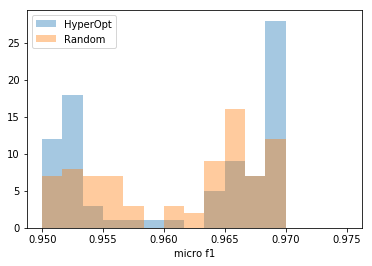

In [31]:
plt.hist(f1s_h, bins=15, range=(0.95, 0.975), alpha=0.4, label='HyperOpt')
plt.hist(f1s_r2, bins=15, range=(0.95, 0.975), alpha=0.4, label='Random')
plt.xlabel('micro f1')
plt.legend()
plt.show()

## ランダムサーチで見つけたF値に対して
## Hyperoptで見つけたF値の方が、